# Semantic segmentation with FCN

### FCN architecture

The neural network consist of an **encoder** and a **decoder**. 

The **encoder** is a fine-tuned version of a pre-trained **VGG-16** neural network where the fully connected layers have been replaced for 1x1 convolutional layers. A 1x1 convolution is used to predict the classes (road or not road). To retain the fine-grain resolution, there are also predictions for intermediate layers that are combined later in the **encoder**

The **decoder** consist of transposed convolutional layers. These layers upsample the predictions of the **encoder** to the original size of the input image. In order to do so, it combines the outputs of the **encoder** at different resolutions and then upsammples them. I have tried different ways of combining the prediction, but a simple addition works well.

Also I have applied non-linear activation functions **(Leaky ReLU)** to both the transposed convolutions and to the predicition layers, improving slightly the pure linear decoder. 

### Training

I have trained the FCN using the **KITTI dataset**. It seems that it trains better with small batch sizes. I think it is because it updates more often the network and it helps with the fine-tuning of the VGG-16. 

I have selected **Adam** as the optimizer as its adaptive momentum simplifies the selection of hyperparameters.

As regularizers I have used **Dropout** for the **encoder** (included in the VGG-16 pretrained model) and **L2** for the **decoder**.

In order to **augment** the small dataset, I have applied a random horizontal flip to the images during the batch generation. I think that other data augmentation technics could work as well (e.g. contrast, rotation, luminosity)

Unfortunately there is not a **validation set** to prevent overfitting of the model. I just can't split the training set randomly as there is lot of correlation in the images  (i.e. they have been extracted from a video) and the training set would leak into the validation set, making it useless for the purpose of preventing overfitting.

All the training sessions have been logged and analysed using **Tensorboard**.



In [61]:
import os.path

import tensorflow as tf
import helper
import warnings
from distutils.version import LooseVersion
import project_tests as tests


# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion(
    '1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn(
        'No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))


def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """

    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'

    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    graph = tf.get_default_graph()
    vgg_input_tensor = graph.get_tensor_by_name(vgg_input_tensor_name)
    vgg_keep_prob_tensor = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    vgg_layer3_out_tensor = graph.get_tensor_by_name(
        vgg_layer3_out_tensor_name)
    vgg_layer4_out_tensor = graph.get_tensor_by_name(
        vgg_layer4_out_tensor_name)
    vgg_layer7_out_tensor = graph.get_tensor_by_name(
        vgg_layer7_out_tensor_name)

    return vgg_input_tensor, vgg_keep_prob_tensor, vgg_layer3_out_tensor, vgg_layer4_out_tensor, vgg_layer7_out_tensor


# tests.test_load_vgg(load_vgg, tf)


def conv1x1(input, filters):
    """
    Create a convolutional 1x1 layer.
    :param input: TF Tensor
    :param filters: Number of output filters
    :return: A Tensor
    """

    # Add non-linear activation function
    l2 = tf.contrib.layers.l2_regularizer(.001)
    out = tf.layers.conv2d(
        input, filters, 1, padding='same', kernel_regularizer=l2)
    out = tf.nn.leaky_relu(out)
    return out


def upsample(input, filters, kernel_size, strides):
    """
    Upsample a layer using a transposed convolution.
    :param input: TF tensor
    :param filters: Number of output filters
    :param strides: Strides of the convolution
    :return: A Tensor
    """

    # Add non-linear activation function
    l2 = tf.contrib.layers.l2_regularizer(.001)

    out = tf.layers.conv2d_transpose(
        input, filters, kernel_size, strides=strides, padding='same', kernel_regularizer=l2)
    out = tf.nn.leaky_relu(out)
    return out


def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer3_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer7_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """

    # To investigate: Use concat instead of add classes.
    # Also we are not adding dropout (It is used for VGG layers)

    # Add a 1x1 convolution to reduce dimensionality to the output layers -> num_classes
    pred_3 = conv1x1(vgg_layer3_out, num_classes)
    pred_4 = conv1x1(vgg_layer4_out, num_classes)
    pred_7 = conv1x1(vgg_layer7_out, num_classes)

    # Upsample last layer and combine (x2)
    pred_7x2 = upsample(pred_7, num_classes, 4, strides=(2, 2))
    pred_4_7x2 = tf.add(pred_4, pred_7x2)
#     pred_4_7x2 = conv1x1(tf.concat([pred_4, pred_7x2], -1), num_classes)

    # Upsample and combine (x2)
    pred_4x2_7x4 = upsample(pred_4_7x2, num_classes, 4, strides=(2, 2))
    pred_3_4x2_7x4 = tf.add(pred_3, pred_4x2_7x4)
#     pred_3_4x2_7x4 = conv1x1(
#         tf.concat([pred_3, pred_4x2_7x4], -1), num_classes)

    # Upsample to final size (x8)
    pred_3x8_4x16_7x32 = upsample(
        pred_3_4x2_7x4, num_classes, 16, strides=(8, 8))
    
#     pred_3x4_4x8_7x16 = upsample(
#         pred_3_4x2_7x4, num_classes, 8, strides=(4, 4))

#     pred_3x8_4x16_7x32 = upsample(
#         pred_3x4_4x8_7x16, num_classes, 2, strides=(2, 2))

    output = pred_3x8_4x16_7x32
    tf.identity(output, 'output')
    
    return pred_3x8_4x16_7x32

# tests.test_layers(layers)


def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """

    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    labels = tf.reshape(correct_label, (-1, num_classes))
    # logits = nn_last_layer
    # labels = correct_label

    # Calculate cross_entropy with logits
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=logits, labels=labels))

    # Add L2 regularization term to the loss
    lambda_l2 = 0.5   # L2 regularization coefficient
    loss = cross_entropy_loss + lambda_l2 * tf.losses.get_regularization_loss()

    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('cross_entropy_loss', cross_entropy_loss)

    return logits, train_op, cross_entropy_loss


# tests.test_optimize(optimize)


def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             logits, correct_label, keep_prob, learning_rate, run_id):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """

    writer = tf.summary.FileWriter('./logs/'+ run_id, flush_secs=20)
    
    num_classes = logits.shape[-1]
    predictions = tf.nn.softmax(logits)
    print(correct_label.shape)

    iou_op, update_op = tf.metrics.mean_iou(
        tf.argmax(tf.reshape(correct_label, (-1, num_classes)), axis=-1),
        tf.argmax(predictions, axis=-1),
        num_classes)
    
    tf.summary.scalar('IoU', iou_op)
    
    sess.run(tf.global_variables_initializer())
    summary_merged = tf.summary.merge_all()

    iteration = 0;
    for epoch_i in range(epochs):
        current_epoch_loss = 0
        sess.run(tf.local_variables_initializer())

        print("Running epoch: " + str(epoch_i + 1))
        for batch_i, (X, y) in enumerate(get_batches_fn(batch_size)):
            iteration += 1
            
            loss, _, _ = sess.run(
                [cross_entropy_loss, update_op, train_op], 
                feed_dict={input_image: X, correct_label: y, keep_prob: 0.7})
            
            current_epoch_loss += loss
            
            print("Training loss for batch {}: {}".format(iteration, loss))
        
        summary, iou = sess.run([summary_merged, iou_op], feed_dict={
                input_image: X, correct_label: y, keep_prob: 1.0})
        
        writer.add_summary(summary, iteration)                  
        print("Training mean loss for epoch {}: {} IoU: {}".format(epoch_i, current_epoch_loss, iou))

# tests.test_train_nn(train_nn)


def run():
    num_classes = 2
    learning_rate = 0.0005
    epochs = 40
    batch_size = 4
    image_shape = (160, 576)
    data_dir = './data'
    runs_dir = './runs'
    tests.test_for_kitti_dataset(data_dir)
    run_id = helper.get_run_id()
    save_path = "checkpoints/dev"

    # Download pretrained vgg model
    helper.maybe_download_pretrained_vgg(data_dir)

    # OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
    # You'll need a GPU with at least 10 teraFLOPS to train on.
    #  https://www.cityscapes-dataset.com/

    tf.reset_default_graph()

    with tf.Session() as sess:
                  
        # Path to vgg model
        vgg_path = os.path.join(data_dir, 'vgg')
        # Create function to get batches
        get_batches_fn = helper.gen_batch_function(
            os.path.join(data_dir, 'data_road/training'), image_shape)

        # OPTIONAL: Augment Images for better results
        #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network
        
        correct_label = tf.placeholder(
            tf.float32, [None, image_shape[0], image_shape[1], num_classes])

        # Build NN using load_vgg, layers, and optimize function
        vgg_input, keep_prob, vgg_layer3, vgg_layer4, vgg_layer7 = load_vgg(
            sess, vgg_path)

        nn = layers(vgg_layer3, vgg_layer4, vgg_layer7, num_classes)
        logits, train_op, cross_entropy_loss = optimize(
            nn, correct_label, learning_rate, num_classes)

        # Train NN using the train_nn function
        train_nn(sess, epochs, batch_size, get_batches_fn, train_op,
                 cross_entropy_loss, vgg_input, logits, correct_label, keep_prob, learning_rate, run_id)

        
        # Save model
        saver = tf.train.Saver()
        saver.save(sess, save_path)
        print('Model Trained and Saved')
        
        helper.save_inference_samples(
            runs_dir, data_dir, sess, image_shape, logits, keep_prob, vgg_input, run_id)

        # OPTIONAL: Apply the trained model to a video


# if __name__ == '__main__':
#     run()



TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


In [2]:
run()

Tests Passed
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
(?, 160, 576, 2)
Running epoch: 1


/home/manolo/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/manolo/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Training loss for batch 1: 33.93506622314453
Training loss for batch 2: 23.569944381713867
Training loss for batch 3: 14.119197845458984
Training loss for batch 4: 8.041900634765625
Training loss for batch 5: 5.749034881591797
Training loss for batch 6: 2.576117515563965
Training loss for batch 7: 2.278855085372925
Training loss for batch 8: 2.3545117378234863
Training loss for batch 9: 2.234971046447754
Training loss for batch 10: 1.7731504440307617
Training loss for batch 11: 1.3349978923797607
Training loss for batch 12: 1.0250176191329956
Training loss for batch 13: 1.031943440437317
Training loss for batch 14: 1.17960786819458
Training loss for batch 15: 0.9599456787109375
Training loss for batch 16: 0.7902268171310425
Training loss for batch 17: 0.8332628607749939
Training loss for batch 18: 0.8739970922470093
Training loss for batch 19: 0.8662694096565247
Training loss for batch 20: 0.8504350185394287
Training loss for batch 21: 0.8564161658287048
Training loss for batch 22: 0.7

Training loss for batch 171: 0.5948159694671631
Training loss for batch 172: 0.5539316534996033
Training loss for batch 173: 0.5681316256523132
Training loss for batch 174: 0.5669598579406738
Training loss for batch 175: 0.567057192325592
Training loss for batch 176: 0.5451012253761292
Training loss for batch 177: 0.5468577146530151
Training loss for batch 178: 0.536711573600769
Training loss for batch 179: 0.5764655470848083
Training loss for batch 180: 0.554470419883728
Training loss for batch 181: 0.5347263813018799
Training loss for batch 182: 0.5619723200798035
Training loss for batch 183: 0.5336534976959229
Training loss for batch 184: 0.5329712629318237
Training loss for batch 185: 0.5351906418800354
Training loss for batch 186: 0.5631259083747864
Training loss for batch 187: 0.516140341758728
Training loss for batch 188: 0.5113722085952759
Training loss for batch 189: 0.5040473341941833
Training loss for batch 190: 0.5107566714286804
Training loss for batch 191: 0.4950239956378

Training loss for batch 337: 0.23228149116039276
Training loss for batch 338: 0.22603701055049896
Training loss for batch 339: 0.2186509668827057
Training loss for batch 340: 0.20152482390403748
Training loss for batch 341: 0.22855135798454285
Training loss for batch 342: 0.22101181745529175
Training loss for batch 343: 0.23247502744197845
Training loss for batch 344: 0.21611489355564117
Training loss for batch 345: 0.18963250517845154
Training loss for batch 346: 0.3455352187156677
Training loss for batch 347: 0.20921356976032257
Training loss for batch 348: 0.2025449275970459
Training loss for batch 349: 0.24812740087509155
Training loss for batch 350: 0.2921202778816223
Training loss for batch 351: 0.21273919939994812
Training loss for batch 352: 0.2544593811035156
Training loss for batch 353: 0.213664248585701
Training loss for batch 354: 0.20482014119625092
Training loss for batch 355: 0.24423348903656006
Training loss for batch 356: 0.253957599401474
Training loss for batch 357: 

Training loss for batch 502: 0.2500021755695343
Training loss for batch 503: 0.20079325139522552
Training loss for batch 504: 0.1284630447626114
Training loss for batch 505: 0.1569773554801941
Training loss for batch 506: 0.19838449358940125
Training loss for batch 507: 0.1532733142375946
Training loss for batch 508: 0.29621052742004395
Training loss for batch 509: 0.19426237046718597
Training loss for batch 510: 0.18937453627586365
Training loss for batch 511: 0.10170339792966843
Training mean loss for epoch 6: 14.194577038288116 IoU: 0.7896666526794434
Running epoch: 8
Training loss for batch 512: 0.20401714742183685
Training loss for batch 513: 0.29062703251838684
Training loss for batch 514: 0.16985520720481873
Training loss for batch 515: 0.20715086162090302
Training loss for batch 516: 0.2260323017835617
Training loss for batch 517: 0.20735274255275726
Training loss for batch 518: 0.1868194192647934
Training loss for batch 519: 0.16877958178520203
Training loss for batch 520: 0.1

Training loss for batch 665: 0.1933107227087021
Training loss for batch 666: 0.13164736330509186
Training loss for batch 667: 0.13195553421974182
Training loss for batch 668: 0.17316049337387085
Training loss for batch 669: 0.19259728491306305
Training loss for batch 670: 0.17970632016658783
Training loss for batch 671: 0.1402157098054886
Training loss for batch 672: 0.14094804227352142
Training loss for batch 673: 0.1660613715648651
Training loss for batch 674: 0.220725879073143
Training loss for batch 675: 0.16212689876556396
Training loss for batch 676: 0.256609708070755
Training loss for batch 677: 0.15737834572792053
Training loss for batch 678: 0.18703123927116394
Training loss for batch 679: 0.14353331923484802
Training loss for batch 680: 0.1747192144393921
Training loss for batch 681: 0.13821397721767426
Training loss for batch 682: 0.16874286532402039
Training loss for batch 683: 0.15512728691101074
Training loss for batch 684: 0.17173300683498383
Training loss for batch 685:

Training loss for batch 830: 0.11909845471382141
Training loss for batch 831: 0.09400069713592529
Training loss for batch 832: 0.14506754279136658
Training loss for batch 833: 0.20949724316596985
Training loss for batch 834: 0.13248582184314728
Training loss for batch 835: 0.12961451709270477
Training loss for batch 836: 0.171509250998497
Training loss for batch 837: 0.29430127143859863
Training loss for batch 838: 0.08299900591373444
Training loss for batch 839: 0.1178431585431099
Training loss for batch 840: 0.1548784375190735
Training loss for batch 841: 0.13988354802131653
Training loss for batch 842: 0.09872403740882874
Training loss for batch 843: 0.1548302322626114
Training loss for batch 844: 0.28173595666885376
Training loss for batch 845: 0.11461546272039413
Training loss for batch 846: 0.12194307893514633
Training loss for batch 847: 0.09116943925619125
Training loss for batch 848: 0.18580417335033417
Training loss for batch 849: 0.23865719139575958
Training loss for batch 8

Training loss for batch 995: 0.16607871651649475
Training loss for batch 996: 0.16141320765018463
Training loss for batch 997: 0.19264908134937286
Training loss for batch 998: 0.10093699395656586
Training loss for batch 999: 0.13138309121131897
Training loss for batch 1000: 0.17491404712200165
Training loss for batch 1001: 0.14011499285697937
Training loss for batch 1002: 0.1224016323685646
Training loss for batch 1003: 0.10856803506612778
Training loss for batch 1004: 0.14908254146575928
Training loss for batch 1005: 0.17793892323970795
Training loss for batch 1006: 0.08136405795812607
Training loss for batch 1007: 0.11220385134220123
Training loss for batch 1008: 0.12515418231487274
Training loss for batch 1009: 0.11625692248344421
Training loss for batch 1010: 0.1399371474981308
Training loss for batch 1011: 0.0966479629278183
Training loss for batch 1012: 0.08075159043073654
Training loss for batch 1013: 0.11255231499671936
Training loss for batch 1014: 0.10264880210161209
Training

Training loss for batch 1156: 0.1156192496418953
Training loss for batch 1157: 0.10498112440109253
Training loss for batch 1158: 0.13848546147346497
Training loss for batch 1159: 0.12222529202699661
Training loss for batch 1160: 0.1131826639175415
Training loss for batch 1161: 0.14156398177146912
Training loss for batch 1162: 0.09893294423818588
Training loss for batch 1163: 0.08783963322639465
Training loss for batch 1164: 0.14924432337284088
Training loss for batch 1165: 0.1786680817604065
Training loss for batch 1166: 0.11107710003852844
Training loss for batch 1167: 0.11243074387311935
Training loss for batch 1168: 0.14530770480632782
Training mean loss for epoch 15: 9.134194478392601 IoU: 0.8619163632392883
Running epoch: 17
Training loss for batch 1169: 0.09233909100294113
Training loss for batch 1170: 0.06671139597892761
Training loss for batch 1171: 0.08450166881084442
Training loss for batch 1172: 0.12830328941345215
Training loss for batch 1173: 0.12521964311599731
Training l

Training loss for batch 1315: 0.10486088693141937
Training loss for batch 1316: 0.11128146201372147
Training loss for batch 1317: 0.16062356531620026
Training loss for batch 1318: 0.11422897130250931
Training loss for batch 1319: 0.0977049395442009
Training loss for batch 1320: 0.10039756447076797
Training loss for batch 1321: 0.10923734307289124
Training loss for batch 1322: 0.12349613755941391
Training loss for batch 1323: 0.08858184516429901
Training loss for batch 1324: 0.0802956074476242
Training loss for batch 1325: 0.12993209064006805
Training loss for batch 1326: 0.07608765363693237
Training loss for batch 1327: 0.07944821566343307
Training loss for batch 1328: 0.11306767910718918
Training loss for batch 1329: 0.16166101396083832
Training loss for batch 1330: 0.08068510890007019
Training loss for batch 1331: 0.0959448292851448
Training loss for batch 1332: 0.06261373311281204
Training loss for batch 1333: 0.12118357419967651
Training loss for batch 1334: 0.07148423790931702
Tra

Training loss for batch 1476: 0.1147342249751091
Training loss for batch 1477: 0.07484714686870575
Training loss for batch 1478: 0.07282636314630508
Training loss for batch 1479: 0.09374819695949554
Training loss for batch 1480: 0.095784991979599
Training loss for batch 1481: 0.10133518278598785
Training loss for batch 1482: 0.10394080728292465
Training loss for batch 1483: 0.11786065995693207
Training loss for batch 1484: 0.05747648701071739
Training loss for batch 1485: 0.08998419344425201
Training loss for batch 1486: 0.10699503868818283
Training loss for batch 1487: 0.0736258327960968
Training loss for batch 1488: 0.08908914029598236
Training loss for batch 1489: 0.1318739503622055
Training loss for batch 1490: 0.09279989451169968
Training loss for batch 1491: 0.07673227041959763
Training loss for batch 1492: 0.10261542350053787
Training loss for batch 1493: 0.06817864626646042
Training loss for batch 1494: 0.08994176983833313
Training loss for batch 1495: 0.10586726665496826
Train

Training loss for batch 1637: 0.07346717268228531
Training loss for batch 1638: 0.09295088797807693
Training loss for batch 1639: 0.06580506265163422
Training loss for batch 1640: 0.1778247356414795
Training loss for batch 1641: 0.05099441856145859
Training loss for batch 1642: 0.07881686091423035
Training loss for batch 1643: 0.11099674552679062
Training loss for batch 1644: 0.05903158336877823
Training loss for batch 1645: 0.08067922294139862
Training loss for batch 1646: 0.06325406581163406
Training loss for batch 1647: 0.08870365470647812
Training loss for batch 1648: 0.10387846827507019
Training loss for batch 1649: 0.0972708910703659
Training loss for batch 1650: 0.07531104981899261
Training loss for batch 1651: 0.0751221552491188
Training loss for batch 1652: 0.11155932396650314
Training loss for batch 1653: 0.08933857083320618
Training loss for batch 1654: 0.08022672683000565
Training loss for batch 1655: 0.08527573198080063
Training loss for batch 1656: 0.08346613496541977
Tra

Training loss for batch 1798: 0.08620563894510269
Training loss for batch 1799: 0.06691007316112518
Training loss for batch 1800: 0.04868590086698532
Training loss for batch 1801: 0.07091030478477478
Training loss for batch 1802: 0.049649618566036224
Training loss for batch 1803: 0.06958524137735367
Training loss for batch 1804: 0.054851822555065155
Training loss for batch 1805: 0.0727718397974968
Training loss for batch 1806: 0.05967211350798607
Training loss for batch 1807: 0.06927017867565155
Training loss for batch 1808: 0.06667983531951904
Training loss for batch 1809: 0.050955869257450104
Training loss for batch 1810: 0.08260586112737656
Training loss for batch 1811: 0.08199544250965118
Training loss for batch 1812: 0.09414800256490707
Training loss for batch 1813: 0.07794436067342758
Training loss for batch 1814: 0.060079269111156464
Training loss for batch 1815: 0.08505521714687347
Training loss for batch 1816: 0.06248448044061661
Training loss for batch 1817: 0.063130132853984

Training loss for batch 1959: 0.15430377423763275
Training loss for batch 1960: 0.10235169529914856
Training loss for batch 1961: 0.06506294757127762
Training loss for batch 1962: 0.0857844427227974
Training loss for batch 1963: 0.12206757068634033
Training loss for batch 1964: 0.12745675444602966
Training loss for batch 1965: 0.05915357917547226
Training loss for batch 1966: 0.10024981200695038
Training loss for batch 1967: 0.1359432190656662
Training loss for batch 1968: 0.12296447902917862
Training loss for batch 1969: 0.12835337221622467
Training loss for batch 1970: 0.04896709695458412
Training loss for batch 1971: 0.04026569426059723
Training mean loss for epoch 26: 5.854348476976156 IoU: 0.9090758562088013
Running epoch: 28
Training loss for batch 1972: 0.10616767406463623
Training loss for batch 1973: 0.08026807755231857
Training loss for batch 1974: 0.09303451329469681
Training loss for batch 1975: 0.08732825517654419
Training loss for batch 1976: 0.07933586090803146
Training 

Training loss for batch 2118: 0.055671192705631256
Training loss for batch 2119: 0.059668466448783875
Training loss for batch 2120: 0.05359271541237831
Training loss for batch 2121: 0.08314839750528336
Training loss for batch 2122: 0.08132153004407883
Training loss for batch 2123: 0.05161719769239426
Training loss for batch 2124: 0.07354595512151718
Training loss for batch 2125: 0.0727488324046135
Training loss for batch 2126: 0.06767459213733673
Training loss for batch 2127: 0.05821662023663521
Training loss for batch 2128: 0.09195156395435333
Training loss for batch 2129: 0.09859507530927658
Training loss for batch 2130: 0.07483457028865814
Training loss for batch 2131: 0.08027492463588715
Training loss for batch 2132: 0.08254711329936981
Training loss for batch 2133: 0.04901272431015968
Training loss for batch 2134: 0.05786219611763954
Training loss for batch 2135: 0.07976774871349335
Training loss for batch 2136: 0.046115294098854065
Training loss for batch 2137: 0.0646389648318290

Training loss for batch 2278: 0.09586639702320099
Training loss for batch 2279: 0.045979149639606476
Training loss for batch 2280: 0.0726245790719986
Training loss for batch 2281: 0.09479465335607529
Training loss for batch 2282: 0.06407236307859421
Training loss for batch 2283: 0.06983643025159836
Training loss for batch 2284: 0.07435537129640579
Training loss for batch 2285: 0.04943783953785896
Training loss for batch 2286: 0.06619041413068771
Training loss for batch 2287: 0.072797492146492
Training loss for batch 2288: 0.058901213109493256
Training loss for batch 2289: 0.07621067017316818
Training loss for batch 2290: 0.08158089220523834
Training loss for batch 2291: 0.060528531670570374
Training loss for batch 2292: 0.04386640712618828
Training loss for batch 2293: 0.04520728811621666
Training loss for batch 2294: 0.052359357476234436
Training loss for batch 2295: 0.07532553374767303
Training loss for batch 2296: 0.05438949167728424
Training loss for batch 2297: 0.07347342371940613

Training loss for batch 2438: 0.06470765173435211
Training loss for batch 2439: 0.05607401952147484
Training loss for batch 2440: 0.06373470276594162
Training loss for batch 2441: 0.06522805243730545
Training loss for batch 2442: 0.09534836560487747
Training loss for batch 2443: 0.06660600751638412
Training loss for batch 2444: 0.0574919767677784
Training loss for batch 2445: 0.10671416670084
Training loss for batch 2446: 0.05087626725435257
Training loss for batch 2447: 0.05020943656563759
Training loss for batch 2448: 0.04502957686781883
Training loss for batch 2449: 0.058759041130542755
Training loss for batch 2450: 0.05836833268404007
Training loss for batch 2451: 0.062133122235536575
Training loss for batch 2452: 0.08620444685220718
Training loss for batch 2453: 0.04415138438344002
Training loss for batch 2454: 0.0484023354947567
Training loss for batch 2455: 0.06690185517072678
Training loss for batch 2456: 0.07348261773586273
Training loss for batch 2457: 0.06444741040468216
Tra

Training loss for batch 2598: 0.030210331082344055
Training loss for batch 2599: 0.03613845631480217
Training loss for batch 2600: 0.06169918552041054
Training loss for batch 2601: 0.055707551538944244
Training loss for batch 2602: 0.036757148802280426
Training loss for batch 2603: 0.051252756267786026
Training loss for batch 2604: 0.04020530357956886
Training loss for batch 2605: 0.055223532021045685
Training loss for batch 2606: 0.07413598150014877
Training loss for batch 2607: 0.04937268793582916
Training loss for batch 2608: 0.11473676562309265
Training loss for batch 2609: 0.05073455348610878
Training loss for batch 2610: 0.05533582717180252
Training loss for batch 2611: 0.045088429003953934
Training loss for batch 2612: 0.04099947586655617
Training loss for batch 2613: 0.047523465007543564
Training loss for batch 2614: 0.05370461568236351
Training loss for batch 2615: 0.06171685457229614
Training loss for batch 2616: 0.04643649980425835
Training loss for batch 2617: 0.03999892994

Training loss for batch 2758: 0.06007395684719086
Training loss for batch 2759: 0.05203378573060036
Training loss for batch 2760: 0.02630572021007538
Training loss for batch 2761: 0.042673785239458084
Training loss for batch 2762: 0.06020651385188103
Training loss for batch 2763: 0.05853433534502983
Training loss for batch 2764: 0.05545130744576454
Training loss for batch 2765: 0.03579813241958618
Training loss for batch 2766: 0.0562264546751976
Training loss for batch 2767: 0.04076829180121422
Training loss for batch 2768: 0.0553319975733757
Training loss for batch 2769: 0.05185950547456741
Training loss for batch 2770: 0.042797524482011795
Training loss for batch 2771: 0.07571268826723099
Training loss for batch 2772: 0.05749602988362312
Training loss for batch 2773: 0.034277863800525665
Training loss for batch 2774: 0.04147971421480179
Training mean loss for epoch 37: 3.962006237357855 IoU: 0.9362269639968872
Running epoch: 39
Training loss for batch 2775: 0.022364867851138115
Train

Training loss for batch 2919: 0.0522286519408226
Training loss for batch 2920: 0.0377596952021122
Training mean loss for epoch 39: 5.494812350720167 IoU: 0.9155306816101074
Model Trained and Saved
Training Finished. Saving test images to: ./runs/1522415524.2205834


### Tensorboard output

![Tensorboard](./tensorboard.png)

## Inference

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy
import glob
%matplotlib inline

In [3]:
def predict(img, load_path='./checkpoints/dev'):

    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:
        loader = tf.train.import_meta_graph('{}.meta'.format(load_path))
        loader.restore(sess, load_path)

        image_input = loaded_graph.get_tensor_by_name('image_input:0')
        keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        output_op = loaded_graph.get_tensor_by_name('output:0')
            
        predict_op = tf.nn.softmax(output_op)
        
        output = sess.run([predict_op], feed_dict={ 
            image_input: img, 
            keep_prob: 1,
        })
        return np.squeeze(output)

In [4]:
image_file = './data/data_road/testing/image_2/um_000000.png'
img = scipy.misc.imresize(scipy.misc.imread(image_file), (160, 576))
out = predict(img[np.newaxis,:])

/home/manolo/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/manolo/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


INFO:tensorflow:Restoring parameters from ./checkpoints/dev


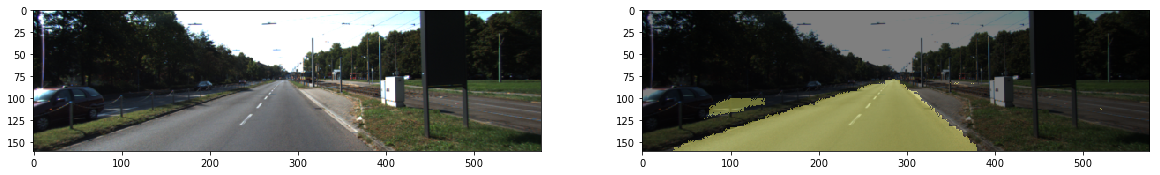

In [5]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
mask = np.dot((out[:,:,1])[:,:,np.newaxis] >.5, np.array([[0.75, 0.75, 0.25]]))
plt.imshow( img/ 512 + mask/2 )


## Video generation

In [6]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import scipy.misc

In [7]:
def display_video(video):
    return HTML('<video width="960" height="540" type="video/mp4" controls src="{}"/>'.format(video))

In [8]:
display_video("./harder_challenge_video.mp4")

In [17]:
def load_model(sess, load_path='./checkpoints/dev'):
    loaded_graph = tf.Graph()
    loader = tf.train.import_meta_graph('{}.meta'.format(load_path))
    loader.restore(sess, load_path)
#     return loaded_graph


In [18]:
def predict(img, sess, graph):
    image_input = graph.get_tensor_by_name('image_input:0')
    keep_prob = graph.get_tensor_by_name('keep_prob:0')
    output_op = graph.get_tensor_by_name('output:0')

    predict_op = tf.nn.softmax(output_op)

    output = sess.run([predict_op], feed_dict={ 
        image_input: img, 
        keep_prob: 1,
    })
    return np.squeeze(output)

In [56]:
def process_video(sess, graph):
    def apply(frame):
        frame = scipy.misc.imresize(frame[-400:-80,...], (160, 576))
        out = predict(frame[np.newaxis,:], sess, graph)
        mask = np.dot((out[:,:,1])[:,:,np.newaxis], np.array([[0.75, 0.75, 0.25]]))
        return frame // 2 + (256 * mask).astype(np.uint8) // 2
    return apply

In [57]:
loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    load_model(sess)
    video = VideoFileClip("./harder_challenge_video.mp4") #.subclip(0,10)
    result = video.fl_image(process_video(sess, loaded_graph))
    _ = result.write_videofile("./project-video-result.mp4", audio=False)
#     tf.get_default_session().close()

INFO:tensorflow:Restoring parameters from ./checkpoints/dev
[MoviePy] >>>> Building video ./project-video-result.mp4
[MoviePy] Writing video ./project-video-result.mp4


100%|█████████▉| 1199/1200 [06:03<00:00,  2.15it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project-video-result.mp4 



In [58]:
display_video("./project-video-result.mp4")